In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import pytensor.tensor as pt

In [2]:
#graphvizを使うためPATHを設定
import os
# Replace 'path_to_graphviz_bin' with the actual path to your Graphviz 'bin' directory.
graphviz_bin_path = '/opt/conda/envs/pymc-dev/bin/'
# Append the Graphviz 'bin' directory to the PATH.
os.environ["PATH"] += os.pathsep + graphviz_bin_path

(array([42., 36., 42., 27., 21., 14., 10.,  5.,  0.,  3.]),
 array([0.01266742, 0.29597968, 0.57929194, 0.86260419, 1.14591645,
        1.42922871, 1.71254097, 1.99585323, 2.27916549, 2.56247774,
        2.84579   ]),
 <BarContainer object of 10 artists>)

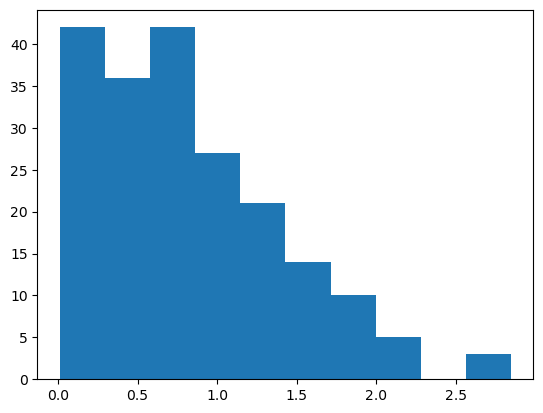

In [63]:
#標準偏差:1の半正規分布をサンプリング
temp1 = pm.HalfNormal.dist(sigma=1,shape=(200,))
a1_true = pm.draw(temp1)

plt.hist(a1_true)

In [19]:
samples.shape

(200,)

(array([ 5.,  8., 15., 29., 44., 39., 28., 16., 12.,  4.]),
 array([-2.49208855, -1.97599316, -1.45989776, -0.94380237, -0.42770698,
         0.08838842,  0.60448381,  1.1205792 ,  1.6366746 ,  2.15276999,
         2.66886538]),
 <BarContainer object of 10 artists>)

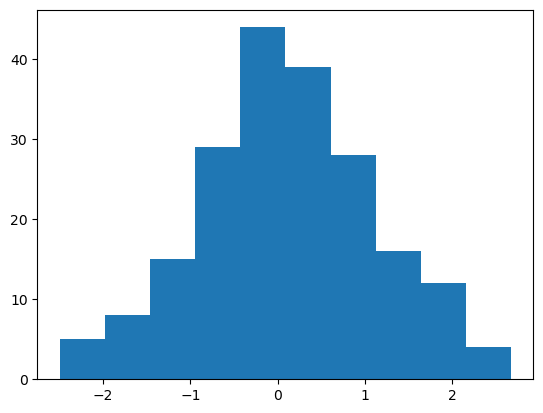

In [64]:
#標準偏差:1の正規分布をサンプリング
temp2 = pm.Normal.dist(sigma=1,shape=(200,))
a2_true = pm.draw(temp2)

plt.hist(a2_true)

In [65]:
pd.DataFrame({'a1_true':a1_true,'a2_true':a2_true})

,a1_true,a2_true
0,1.140375,0.023631
1,0.102478,0.184131
2,0.390169,0.690953
3,1.452781,-0.635428
4,0.423254,-1.253346
...,...,...
195,0.315329,-0.075749
196,1.390524,-0.573105
197,0.122910,0.181826
198,0.883642,-0.303531


## 考え方  
a1_trueは半正規分布からサンプルした200の値　a2_trueは正規分布からサンプルした200の値  
↑が推定したい事前分布  
次に2×200行の一様分布からサンプルした特徴量を生成する(いわゆる観測できる値)

In [45]:
# 下限0,上限1の一様分布から200個サンプル
temp3 = pm.Uniform.dist(lower=0, upper=1,shape=(200,))
temp4 = pm.Uniform.dist(lower=0, upper=1,shape=(200,))
x1 = pm.draw(temp3)
x2 = pm.draw(temp4)

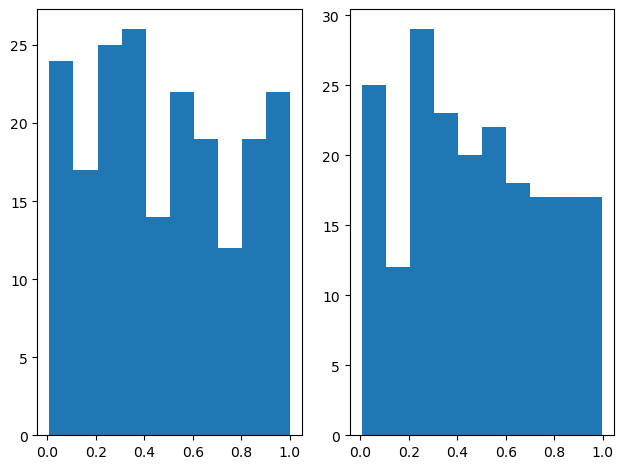

In [60]:
# 作成したx1,x2を可視化
fig ,ax = plt.subplots(1,2)
ax[0].hist(x1)
ax[1].hist(x2)
fig.tight_layout()

In [66]:
# 真の値を利用した目的変数を作成　変数複数
y = x1 *a1_true + x2 *a2_true

In [67]:
y

array([ 0.66580546,  0.05640241,  0.2908729 , -0.19710598,  0.26667341,
       -0.1728508 ,  0.29946245,  0.84999388, -0.09520896, -0.4577092 ,
        1.00610315,  1.9103708 ,  2.2370691 ,  0.33924343,  0.92909592,
        0.46292825,  2.12174904,  0.43559542,  0.21431743,  1.00063674,
        1.3695949 ,  0.29392803,  0.44764038,  1.44692224,  0.54873956,
       -0.02236392, -0.09998428,  0.85176927,  0.09499573, -0.01101454,
        0.44013058,  0.82568238,  1.98247134,  1.02694997,  0.53944873,
        0.26829505,  1.89152568,  0.35982261,  2.27256576,  1.52993801,
        0.56166673,  0.41729814,  0.70314276,  2.88222231,  1.14665717,
       -0.42539594,  0.95805625, -0.00944268,  0.77128311,  0.01876187,
       -0.30670943,  0.90104406, -0.87535212,  2.08071095,  0.64907008,
        0.26550512, -1.15934231, -0.08730935,  1.51453527,  1.61787121,
       -0.02693005,  1.49780075,  0.52125171,  1.06890638,  0.32824678,
       -0.30481026,  0.7656107 , -0.67467959,  0.00916433,  0.68

(array([ 2.,  6., 22., 58., 56., 29., 10., 10.,  6.,  1.]),
 array([-1.4417749 , -1.00937518, -0.57697546, -0.14457574,  0.28782398,
         0.7202237 ,  1.15262342,  1.58502315,  2.01742287,  2.44982259,
         2.88222231]),
 <BarContainer object of 10 artists>)

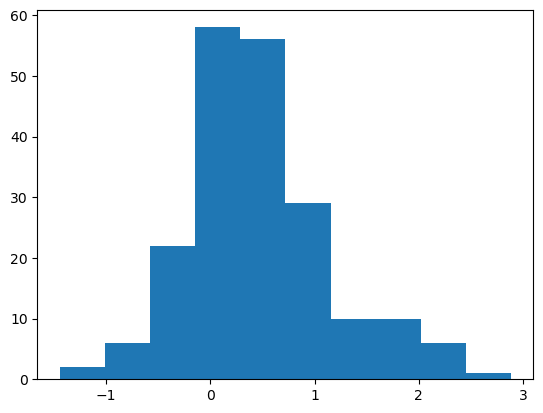

In [70]:
plt.hist(y)

In [68]:
df1 = pd.DataFrame({'x1':x1,'x2':x2, 'y':y})

In [69]:
# 観測できているデータを確認
df1

,x1,x2,y
0,0.583305,0.026193,0.665805
1,0.331583,0.121775,0.056402
2,0.057190,0.388679,0.290873
3,0.143585,0.638472,-0.197106
4,0.941479,0.105167,0.266673
...,...,...,...
195,0.738923,0.238910,0.214907
196,0.566495,0.403544,0.556452
197,0.916161,0.953535,0.285983
198,0.399396,0.328273,0.253283


## モデルを作成  
x1には半正規分布の事前分布を設定  
x２には正規分布の事前分布を設定  
y(尤度)は正規分布

In [72]:
df_x1=df1['x1']
df_x2=df1['x2']
df_y =df1['y']

In [140]:
model1 = pm.Model()

In [141]:
with model1:
    model1.add_coord('data',df_x1.index, mutable=True)
    model1.add_coord('var',df1.columns, mutable=True)
    x1_data= pm.Data("x1_data", df_x1, dims=('data'), mutable=True)
    x2_data= pm.Data("x2_data", df_x2, dims=('data'), mutable=True)
    y_data = pm.Data("y_data", df_y, dims=('data'), mutable=True)

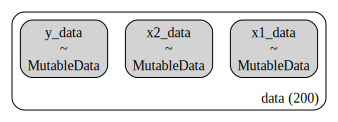

In [142]:
pm.model_to_graphviz(model1)

In [143]:
with model1:
    #切片を標準偏差100の正規分布で定義
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    #x1の傾きを半正規分布で定義
    a1 = pm.HalfNormal("a1", sigma=100)
    #x2の傾きを正規分布で定義
    a2= pm.Normal("a2",mu=0, sigma=100)
    
    #誤差を半正規分布で定義
    epsilon = pm.HalfNormal("epsilon", sigma=100)

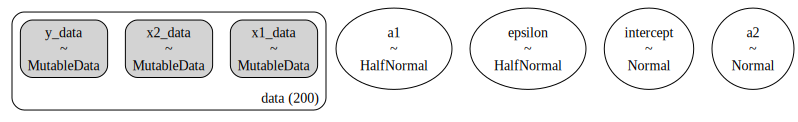

In [144]:
pm.model_to_graphviz(model1)

In [145]:
with model1:
    #観測データ(正規分布を仮定)の平均を計算　重回帰の計算結果が平均となる
    mu = pm.Deterministic("mu", intercept + pt.dot(x1_data, a1) + pt.dot(x2_data,a2), dims=('data',))
    
    #観測データ(尤度)(正規分布を仮定)を定義
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y_data, dims=('data',)) 

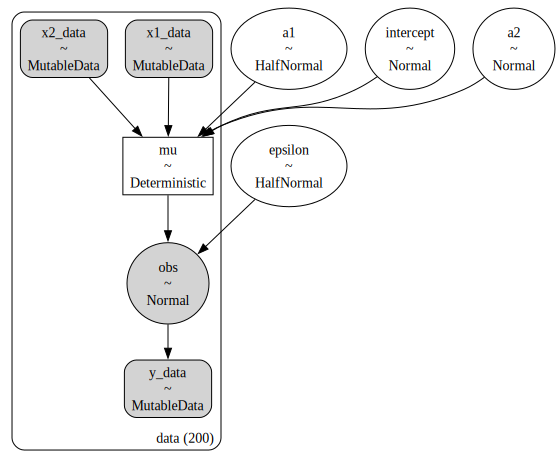

In [146]:
pm.model_to_graphviz(model1)

In [147]:
# MCMC実行
with model1:
    idata1 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, a1, a2, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 182 seconds.


In [157]:
#R_hat 1.0のため収束出来てそう
summary1 = az.summary(idata1,var_names=['a1','a2','epsilon'])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.902,0.162,0.609,1.214,0.003,0.002,2423.0,2305.0,1.0
a2,0.099,0.169,-0.211,0.423,0.004,0.003,1886.0,2244.0,1.0
epsilon,0.657,0.033,0.596,0.716,0.001,0.000,2950.0,2477.0,1.0


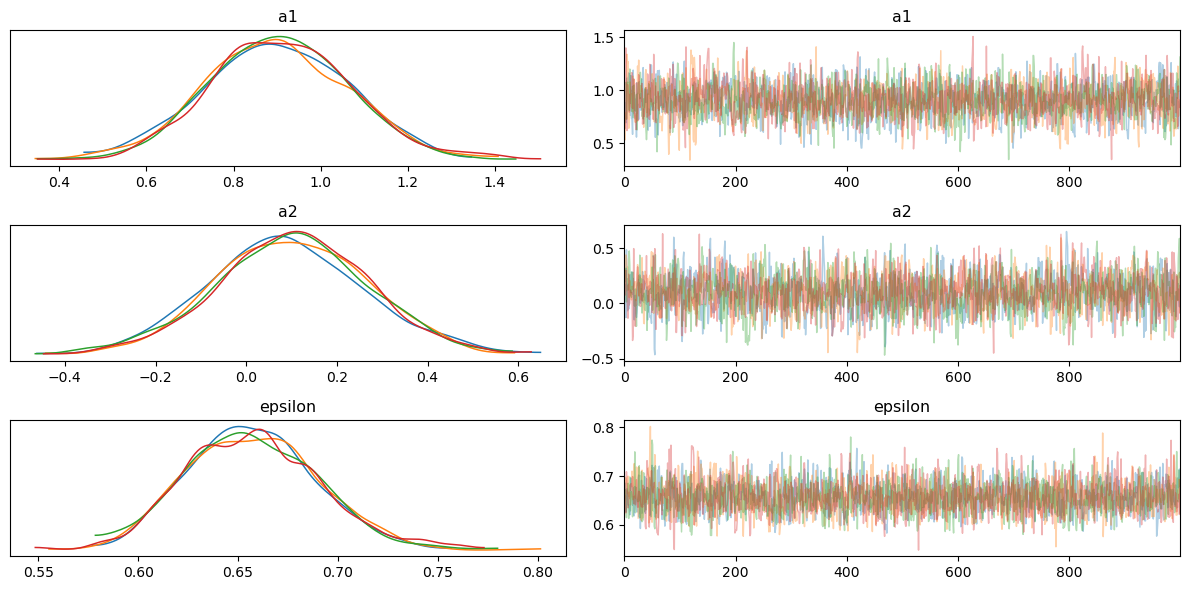

In [150]:
az.plot_trace(idata1, compact=False, var_names=['a1','a2','epsilon'])
plt.tight_layout()

array([<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a2'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

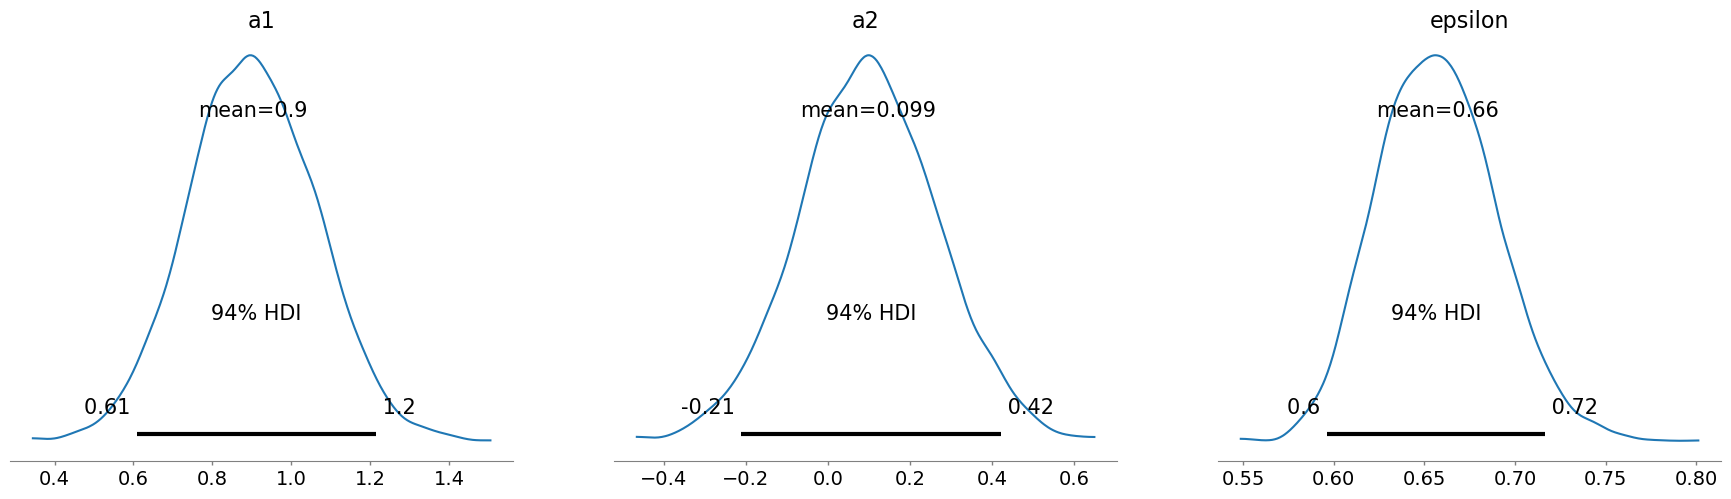

In [156]:
az.plot_posterior(idata1, var_names=['a1','a2','epsilon'])

## MCMCの結果考察  
R_hatが1.0、グラフも定常状態になっているため収束出来ていると判断

## 真の値とMCMCの結果の比較

In [160]:
a1_true.mean()

0.828636611601724

In [164]:
idata1['posterior']['a1'].values.mean()

0.9023665239968437

In [165]:
a2_true.mean()

0.11801374745527411

In [166]:
idata1['posterior']['a2'].values.mean()

0.09860694674297064

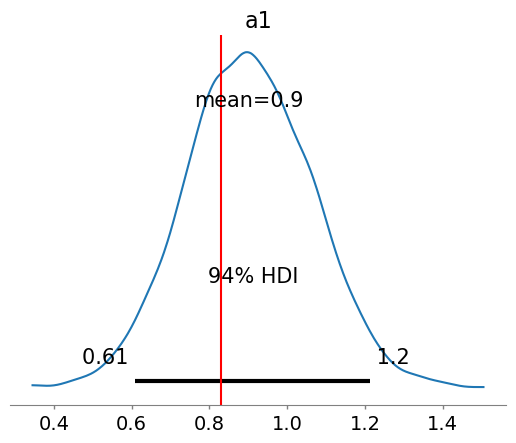

In [176]:
az.plot_posterior(idata1, var_names=['a1'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a1_true.mean(),color='red')

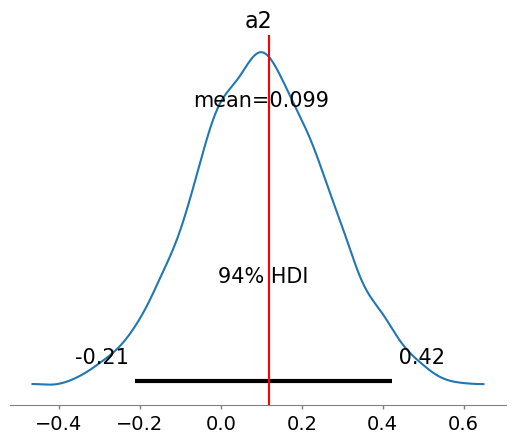

In [177]:
az.plot_posterior(idata1, var_names=['a2'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a2_true.mean(),color='red')

## 94％区間に収まっているためよく推定できている